### Lib Imports and Reproducibility

In [18]:
# setup modes
preprocessing_verbose = 0
train_verbose = 1

In [19]:
# !pip install torchsummary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import random
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from IPython.display import display

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = "cuda" if torch.cuda.is_available() else "cpu"


In [20]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
random.seed(seed)

from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Define  Transform
for training and for general inputs

In [21]:
img_size = 224
transform_train = transforms.Compose(
    [transforms.Resize((256,256), interpolation=transforms.functional.InterpolationMode.BILINEAR),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((img_size,img_size), interpolation=transforms.functional.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

batch_size = 64

In [22]:
# train_dir = ".\\train\\"
train_dir = ".\\resized\\"
# train_dir = "/kaggle/input/2110446-data-science-and-data-engineering-2023/TraffyFondue/train/"
image_classes = ["canal", "electric" , "flooding" , "light" , "road" ,\
                 "sanitary" , "sewer" , "sidewalk" , "stray" , "traffic" ]

def get_images(path, img_class, img_label):
   images = []
   for root, dirs, files in os.walk(path+img_class, topdown=True):
      for name in files:
         images.append((os.path.join(root, name), img_label))
   return images

train_images_list = []
distinct_img_count = 0
for idx, img_class in enumerate(image_classes):
   img_paths = get_images(train_dir, img_class, idx)
   distinct_img_count += len(img_paths)
   if len(img_paths) >1600:
      train_images_list.extend(img_paths)
   elif len(img_paths) > 1000:
      train_images_list.extend(img_paths*2)
   elif len(img_paths) > 600:
      train_images_list.extend(img_paths*3)
   else:
      train_images_list.extend(img_paths*5)

print("distinct_img_count: ", distinct_img_count)
print("train_images_list: ", len(train_images_list))
img_pool = pd.DataFrame(train_images_list, columns=["image_path", "label"])


distinct_img_count:  13274
train_images_list:  27679


In [23]:
# analysis data
# display each class distribution
# display class id as class name
if preprocessing_verbose:
    img_pool["label_name"] = img_pool["label"].apply(lambda x: image_classes[x])
    display(img_pool["label_name"].value_counts())
    display(img_pool["label_name"].value_counts()/len(img_pool)*100)

# original data
# road        3403
# flooding    2266
# electric    1535
# light       1400
# canal       1270
# sidewalk    1000
# sanitary     700
# sewer        600
# traffic      600
# stray        500
# Name: label_name, dtype: int64road        25.636583
# flooding    17.070966
# electric    11.563960
# light       10.546934
# canal        9.567576
# sidewalk     7.533524
# sanitary     5.273467
# sewer        4.520115
# traffic      4.520115
# stray        3.766762
# Name: label_name, dtype: float64



In [24]:
# try show image
if preprocessing_verbose:
    img_entry = img_pool.iloc[8]
    img = Image.open(img_entry["image_path"])
    img = transform_train(img)
    display(img.shape)
    img = img.numpy().transpose(1,2,0)
    plt.imshow(img)
    plt.title(img_entry["label"])

In [25]:
from torchvision.io import read_image
class TraffyFondueDataset(Dataset):
    def __init__(self, train_imgs:pd.DataFrame, transform=None, train=True):
        super().__init__()
        self.train_images = train_imgs
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return len(self.train_images)
    
    def __getitem__(self, idx):
        if self.train:
            img = Image.open(self.train_images[idx][0]).convert('RGB')
            label = self.train_images[idx][1]
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = Image.open(self.train_images[idx][1]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img


### Train/Test split

In [26]:
# train: 80%, val: 10%, test: 10%
# stratify: make sure the distribution of each class is the same in train, val, test
from sklearn.model_selection import train_test_split
# proxy = img_pool.sample(frac=1, random_state=seed).reset_index(drop=True)
proxy = img_pool
train_images, valtest_images = train_test_split(proxy, test_size=0.2, random_state=seed, stratify=proxy["label"])
val_images, test_images = train_test_split(valtest_images, test_size=0.5, random_state=seed, stratify=valtest_images["label"])

# make dataset
train_dataset = TraffyFondueDataset(train_images.values, transform=transform_train)
val_dataset = TraffyFondueDataset(val_images.values, transform=transform)
test_dataset = TraffyFondueDataset(test_images.values, transform=transform)

# make dataloader
NUM_WORKERS =8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,)


In [27]:
# Validate stratify
if preprocessing_verbose:
    print("train")
    display(train_images["label"].value_counts())
    display(train_images["label"].value_counts()/len(train_images)*100)
    print("val")
    display(val_images["label"].value_counts())
    display(val_images["label"].value_counts()/len(val_images)*100)
    print("test")
    display(test_images["label"].value_counts())
    display(test_images["label"].value_counts()/len(test_images)*100)

In [28]:
# function to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if preprocessing_verbose:
    # get some random training images
    dataiter = iter(val_loader)
    images, labels = next(dataiter)

    # show images
    nrow = 8
    imshow(torchvision.utils.make_grid(images, nrow=nrow))
    # print labels
    for i in [[image_classes[labels[j]] for j in range(i*nrow, (i+1)*nrow)] for i in range(4)]:
        print(("  \t".join(i)+"\n").expandtabs(20))

## Making Model

In [29]:
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from tqdm import tqdm
# import classification report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


# defining the model
num_classes=10
model_ft = torchvision.models.mnasnet0_5(weights='IMAGENET1K_V1')
model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=1280, out_features=num_classes),
    nn.Softmax(dim=1)
        )

In [30]:

print(device)
net = model_ft.to(device)

cuda


In [31]:
from torchsummary import summary
summary(net, (3, img_size, img_size), batch_size = batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 112, 112]             432
       BatchNorm2d-2         [64, 16, 112, 112]              32
              ReLU-3         [64, 16, 112, 112]               0
            Conv2d-4         [64, 16, 112, 112]             144
       BatchNorm2d-5         [64, 16, 112, 112]              32
              ReLU-6         [64, 16, 112, 112]               0
            Conv2d-7          [64, 8, 112, 112]             128
       BatchNorm2d-8          [64, 8, 112, 112]              16
            Conv2d-9         [64, 24, 112, 112]             192
      BatchNorm2d-10         [64, 24, 112, 112]              48
             ReLU-11         [64, 24, 112, 112]               0
           Conv2d-12           [64, 24, 56, 56]             216
      BatchNorm2d-13           [64, 24, 56, 56]              48
             ReLU-14           [64, 24,

In [32]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [33]:
NUM_EPOCHS = 20
MODEL_DIR = "models"
# MODEL_DIR = "/kaggle/working/models"
model_name = "efficientnet_b0_v1"
model_path = os.path.join(MODEL_DIR, model_name)

# if the model directory is not exist, create it
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

### TRAINING

In [34]:
import time
# training
history_train = {"loss":np.zeros(NUM_EPOCHS), "acc":np.zeros(NUM_EPOCHS), "f1":np.zeros(NUM_EPOCHS)}
history_val = {"loss":np.zeros(NUM_EPOCHS), "acc":np.zeros(NUM_EPOCHS), "f1":np.zeros(NUM_EPOCHS)}
min_val_loss = np.inf
best_epoch = 0
epoch_start = time.time()
for epoch in range(NUM_EPOCHS):
    print("finished: time = {:.5f} sec".format(time.time()-epoch_start))
    print("Epoch {}/{}".format(epoch+1, NUM_EPOCHS))
    epoch_start = time.time()
    net.train()
    y_pred = []
    y_label = []
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        if train_verbose:
            pbar = tqdm(train_loader)
        else:
            pbar = train_loader
        for data in pbar:

            # prepare data
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            # backward + optimize
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            training_loss += loss.item()
            n += 1

            y_label.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
    
    scheduler.step()
    # calculate loss and accuracy of training
    if train_verbose:
        report = classification_report(y_label, y_pred, output_dict=True)
        acc = report["accuracy"]
        f1 = report["macro avg"]["f1-score"]
        pbar.set_description("loss: {:.4f}, acc: {:.4f}, f1: {:.4f}".format(training_loss/n, acc, f1))
        pbar.set_description("loss: {:.4f}".format(loss.item()))
        pbar.update(1)
        pbar.close()
    history_train["loss"][epoch] = training_loss/n
    history_train["acc"][epoch] = acc
    history_train["f1"][epoch] = f1

    # validation
    # print("Validation")
    net.eval()
    y_pred = []
    y_label = []
    val_loss = 0.0
    n = 0

    optimizer.zero_grad()
    with torch.no_grad():
        if train_verbose:
            pbar = tqdm(val_loader)
        else:
            pbar = val_loader
        for data in pbar:
            # prepare data
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            # statistics
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            n += 1

            y_label.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # calculate loss and accuracy of validation
    if train_verbose:
        report = classification_report(y_label, y_pred, output_dict=True)
        acc = report["accuracy"]
        f1 = report["macro avg"]["f1-score"]
        pbar.set_description("loss: {:.4f}, acc: {:.4f}, f1: {:.4f}".format(val_loss/n, acc, f1))
        pbar.update(1)
        pbar.close()
        # print acc and f1 to console
        print("loss: {:.4f}, acc: {:.4f}, f1: {:.4f}".format(val_loss/n, acc, f1))

    history_val["loss"][epoch] = val_loss/n
    history_val["acc"][epoch] = acc
    history_val["f1"][epoch] = f1

    # save the model if the validation loss is decreased
    if val_loss/n < min_val_loss:
        torch.save(net.state_dict(), model_path)
        min_val_loss = val_loss/n
        best_epoch = epoch
    

# report the training and validation loss and accuracy of the saved model
print("Finish training")
print("best model achieved {:.4f} loss on validation set".format(min_val_loss))
print("from epoch {}".format(best_epoch+1))

finished: time = 0.00000 sec
Epoch 1/25


100%|██████████| 44/44 [00:05<00:00,  8.76it/s]


loss: 2.0028, acc: 0.4570, f1: 0.3895
finished: time = 63.82334 sec
Epoch 2/25


100%|██████████| 44/44 [00:04<00:00,  8.94it/s]


loss: 1.9470, acc: 0.5116, f1: 0.4814
finished: time = 62.83357 sec
Epoch 3/25


100%|██████████| 44/44 [00:04<00:00,  8.85it/s]


loss: 1.9580, acc: 0.5029, f1: 0.4741
finished: time = 63.16102 sec
Epoch 4/25


100%|██████████| 44/44 [00:05<00:00,  8.79it/s]


loss: 1.9296, acc: 0.5318, f1: 0.5104
finished: time = 63.97995 sec
Epoch 5/25


100%|██████████| 44/44 [00:05<00:00,  8.70it/s]


loss: 1.9351, acc: 0.5206, f1: 0.4980
finished: time = 63.82100 sec
Epoch 6/25


100%|██████████| 44/44 [00:04<00:00,  8.88it/s]


loss: 1.9218, acc: 0.5336, f1: 0.5059
finished: time = 63.61200 sec
Epoch 7/25


100%|██████████| 44/44 [00:04<00:00,  8.83it/s]


loss: 1.8952, acc: 0.5647, f1: 0.5476
finished: time = 63.50441 sec
Epoch 8/25


100%|██████████| 44/44 [00:05<00:00,  8.63it/s]


loss: 1.8835, acc: 0.5784, f1: 0.5620
finished: time = 63.62225 sec
Epoch 9/25


100%|██████████| 44/44 [00:04<00:00,  8.94it/s]


loss: 1.8720, acc: 0.5853, f1: 0.5750
finished: time = 63.01001 sec
Epoch 10/25


100%|██████████| 44/44 [00:04<00:00,  8.98it/s]


loss: 1.8652, acc: 0.5983, f1: 0.5860
finished: time = 62.86806 sec
Epoch 11/25


100%|██████████| 44/44 [00:04<00:00,  8.92it/s]


loss: 1.8498, acc: 0.6109, f1: 0.6029
finished: time = 63.12629 sec
Epoch 12/25


100%|██████████| 44/44 [00:04<00:00,  8.89it/s]


loss: 1.8404, acc: 0.6207, f1: 0.6116
finished: time = 62.94145 sec
Epoch 13/25


100%|██████████| 44/44 [00:04<00:00,  8.90it/s]


loss: 1.8318, acc: 0.6304, f1: 0.6226
finished: time = 62.75001 sec
Epoch 14/25


100%|██████████| 44/44 [00:04<00:00,  8.90it/s]


loss: 1.8241, acc: 0.6420, f1: 0.6363
finished: time = 63.01595 sec
Epoch 15/25


100%|██████████| 44/44 [00:04<00:00,  8.87it/s]


loss: 1.8137, acc: 0.6517, f1: 0.6499
finished: time = 62.99161 sec
Epoch 16/25


100%|██████████| 44/44 [00:04<00:00,  8.90it/s]


loss: 1.8114, acc: 0.6528, f1: 0.6512
finished: time = 62.90265 sec
Epoch 17/25


100%|██████████| 44/44 [00:04<00:00,  8.90it/s]


loss: 1.8103, acc: 0.6535, f1: 0.6515
finished: time = 62.89852 sec
Epoch 18/25


100%|██████████| 44/44 [00:05<00:00,  8.76it/s]


loss: 1.8067, acc: 0.6561, f1: 0.6542
finished: time = 63.14668 sec
Epoch 19/25


100%|██████████| 44/44 [00:04<00:00,  8.83it/s]


loss: 1.7994, acc: 0.6647, f1: 0.6626
finished: time = 62.90384 sec
Epoch 20/25


100%|██████████| 44/44 [00:04<00:00,  8.94it/s]


loss: 1.7976, acc: 0.6680, f1: 0.6664
finished: time = 62.88101 sec
Epoch 21/25


100%|██████████| 44/44 [00:05<00:00,  8.54it/s]


loss: 1.7989, acc: 0.6622, f1: 0.6626
finished: time = 65.49700 sec
Epoch 22/25


100%|██████████| 44/44 [00:05<00:00,  8.72it/s]


loss: 1.7949, acc: 0.6694, f1: 0.6688
finished: time = 63.81400 sec
Epoch 23/25


100%|██████████| 44/44 [00:04<00:00,  8.86it/s]


loss: 1.7888, acc: 0.6749, f1: 0.6728
finished: time = 63.24180 sec
Epoch 24/25


100%|██████████| 44/44 [00:04<00:00,  8.81it/s]


loss: 1.7896, acc: 0.6752, f1: 0.6748
finished: time = 63.25600 sec
Epoch 25/25


100%|██████████| 44/44 [00:05<00:00,  8.74it/s]

loss: 1.7885, acc: 0.6738, f1: 0.6742
Finish training
best model achieved 1.7885 loss on validation set
from epoch 25


Monitoring

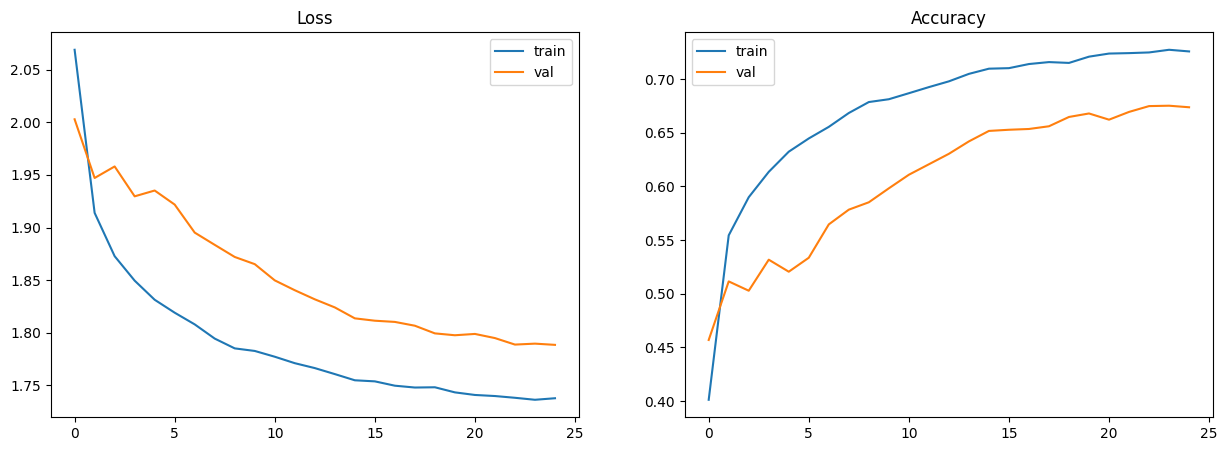

In [35]:
# plot the training and validation loss and accuracy history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_train["loss"], label="train")
plt.plot(history_val["loss"], label="val")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_train["acc"], label="train")
plt.plot(history_val["acc"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

Evaluate on test set


100%|██████████| 44/44 [00:05<00:00,  8.09it/s]


{'0': {'precision': 0.8010471204188482, 'recall': 0.6023622047244095, 'f1-score': 0.6876404494382024, 'support': 254}, '1': {'precision': 0.6869565217391305, 'recall': 0.7719869706840391, 'f1-score': 0.7269938650306749, 'support': 307}, '2': {'precision': 0.6647727272727273, 'recall': 0.5154185022026432, 'f1-score': 0.5806451612903226, 'support': 227}, '3': {'precision': 0.6211340206185567, 'recall': 0.8607142857142858, 'f1-score': 0.7215568862275449, 'support': 280}, '4': {'precision': 0.44884488448844884, 'recall': 0.4, 'f1-score': 0.4230171073094868, 'support': 340}, '5': {'precision': 0.7628205128205128, 'recall': 0.5666666666666667, 'f1-score': 0.6502732240437158, 'support': 210}, '6': {'precision': 0.8508474576271187, 'recall': 0.8366666666666667, 'f1-score': 0.8436974789915967, 'support': 300}, '7': {'precision': 0.7180327868852459, 'recall': 0.73, 'f1-score': 0.7239669421487602, 'support': 300}, '8': {'precision': 0.8340248962655602, 'recall': 0.804, 'f1-score': 0.8187372708757

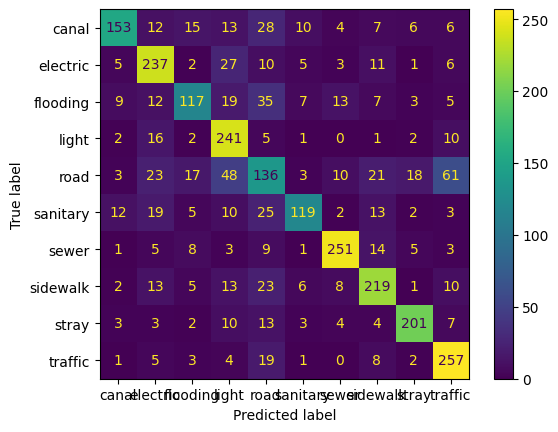

In [36]:
# load the saved model

net.load_state_dict(torch.load(model_path))

# evaluate the model on test set
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

print("Evaluate on test set")
yval_pred = []
yval_label = []
test_loss = 0.0
n = 0
with torch.no_grad():
    if train_verbose:
        pbar = tqdm(test_loader)
    else:
        pbar = test_loader
    for data in pbar:
        # prepare data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        loss = criteria(outputs, labels)
        test_loss += loss.item()
        n += 1

        yval_label.extend(labels.cpu().numpy())
        yval_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # calculate loss and accuracy of validation
    # print(yval_label)
    # print(yval_pred)
    if train_verbose:
        report = classification_report(yval_label, yval_pred, output_dict=True)
        acc = report["accuracy"]
        f1 = report["macro avg"]["f1-score"]
        M = confusion_matrix(yval_label, yval_pred)
        print(report)
        # print(M)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=image_classes)
        disp.plot()
        plt.show()

### Result

In [37]:
submission = pd.DataFrame(columns=['ID', 'filepath'])
# get all file names in ./test
test_dir = "./test"
for filename in os.listdir(test_dir):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Open the image file
            image_path = os.path.join(test_dir, filename)
            submission = submission.append({'ID': filename.removeprefix("test").removesuffix(".jpg"), 'filepath': image_path}, ignore_index=True)

# create a dataset for test set
sub_dataset = TraffyFondueDataset(submission.values, transform=transform, train=False)

# create a dataloader for test set
sub_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False)

# evaluate the model on test set
print("Evaluate on test set")
ytest_pred = []
with torch.no_grad():
    if train_verbose:
        pbar = tqdm(sub_loader)
    else:
        pbar = test_loader
    for data in pbar:
        # prepare data
        inputs = data
        inputs = inputs.to(device)

        # forward
        outputs = net(inputs)

        # statistics
        ytest_pred.extend(outputs.argmax(dim=1).cpu().numpy())

submission['class'] = ytest_pred
submission.to_csv('submission.csv', columns=['ID','class'], index=False)


Evaluate on test set


100%|██████████| 73/73 [01:50<00:00,  1.52s/it]


In [38]:
submission['class'] = ytest_pred
submission.to_csv('submission.csv', columns=['ID','class'], index=False)